In [ ]:
# TODO: Transfer code to google colab :)))))

In [20]:
import numpy as np
import scipy.io as sio
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [21]:
def aggregate_feature(mat_path, index, time_steps):

    mat = sio.loadmat(mat_path)
    feature = mat[index].squeeze().T
    
    aggregated = []

    for step in time_steps:
        start = step["frame_start"]
        end   = step["frame_end"]

        if end > start:
            agg = feature[start:end].mean(axis=0)
        else:
            agg = feature[start]

        aggregated.append(agg)

    return np.vstack(aggregated)

In [32]:
def create_file_indices(root_dir):
    mfcc_dir = os.path.join(root_dir, "MFCCs")
    hpcp_dir = os.path.join(root_dir, "HPCPs")
    cens_dir = os.path.join(root_dir, "CENS")
    beats_dir = os.path.join(root_dir, "Beats")
    meta_dir = os.path.join(root_dir, "Metadata")

    indices = []

    for folder in sorted(os.listdir(mfcc_dir)):
        for file in sorted(os.listdir(os.path.join(mfcc_dir, folder))):

            file_name = file[:file.index("_")]
            
            entry = {
                "mfcc": os.path.join(mfcc_dir, folder, file),
                "hpcp": os.path.join(hpcp_dir, folder, f"{file_name}_HPCP.mat"),
                "cens": os.path.join(cens_dir, folder, f"{file_name}_CENS.mat"),
                "beats": os.path.join(beats_dir, folder, f"{file_name}_Beats.mat"),
                "meta": os.path.join(meta_dir, folder, f"{file_name}.txt")
            }

            indices.append(entry)
    return indices

In [33]:
dirs = create_file_indices(".")
print(dirs[0])

{'mfcc': './MFCCs/1/174702_MFCC.mat', 'hpcp': './HPCPs/1/174702_HPCP.mat', 'cens': './CENS/1/174702_CENS.mat', 'beats': './Beats/1/174702_Beats.mat', 'meta': './Metadata/1/174702.txt'}


In [23]:
def find_meta_data(filepath):

    with open(filepath) as f:
        data = f.read().split("\n")
    
    return data

In [24]:
def determine_time_steps(beats, hop_size, fs):

    beat_times = beats * hop_size / fs
    durations = np.diff(beat_times)

    time_steps = []
    for t in range(len(beats) - 1):
        time_steps.append({
            "frame_start": int(beats[t]),
            "frame_end": int(beats[t + 1]),
            "duration": durations[t]
        })

    return time_steps

In [34]:
class Covers1000Dataset(Dataset):

    def __init__(
            self,
            file_indices
    ):
        
        self.file_indices = file_indices
    
    def __len__(self):
        return len(self.file_indices)

    def __getitem__(self, idx):

        mat_path = self.file_indices[idx]["beats"]
        mat = sio.loadmat(mat_path)

        fs = mat['Fs'].item()
        hop_size = mat['hopSize'].item()
        beats0 = mat['beats0'].squeeze()
        beat_times_in_sec = beats0 * hop_size / fs
        beat_durations = np.diff(beat_times_in_sec)

        time_steps = determine_time_steps(beats0, hop_size, fs)

        mfcc_beat = aggregate_feature(self.file_indices[idx]["mfcc"], 'XMFCC', time_steps)
        hpcp_beat = aggregate_feature(self.file_indices[idx]["hpcp"], 'XHPCP', time_steps)
        cens_beat = aggregate_feature(self.file_indices[idx]["cens"], 'XCENS', time_steps)

        meta_data = find_meta_data(self.file_indices[idx]["meta"])

        tempo_inst = 60.0 / beat_durations
        tempo_features = np.column_stack([
                tempo_inst,
                np.log(tempo_inst),
                np.diff(np.concatenate([[tempo_inst[0]], tempo_inst]))
            ])

        X = np.hstack([
            mfcc_beat,
            hpcp_beat,
            cens_beat,
            tempo_features
        ])

        X = torch.tensor(X, dtype=torch.float32)
        durations = torch.tensor(beat_durations, dtype=torch.float32)

        return {
            "X": X,                    # (T, D)
            "durations": durations,    # (T,)
            "meta_data": meta_data
        }
    

In [26]:
def collate_fn(batch):
    return batch

In [35]:

mat_files = create_file_indices(".")

loader = DataLoader(
    Covers1000Dataset(mat_files),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
)

In [36]:
batch = next(iter(loader))
print(type(batch))
print(len(batch))

<class 'list'>
1


In [ ]:
sample = batch[0]

print(sample['meta_data'])


["Surfin' Safari", 'Beach Boys', 'June 4, 1962', 'First release']
["Surfin' Safari", 'Beach Boys', 'June 4, 1962', 'First release']


In [38]:
X = sample["X"]
durations = sample["durations"]

print("X shape:", X.shape)
print("durations shape:", durations.shape)


X shape: torch.Size([321, 47])
durations shape: torch.Size([321])


In [39]:
assert X.shape[0] == durations.shape[0]

In [40]:
assert not torch.isnan(X).any()
assert not torch.isinf(X).any()

assert X.shape[0] > 5

In [58]:
print("Feature mean:", X.mean(dim=0)[:5])
print("Feature std:", X.std(dim=0)[:5])

print("Duration mean (sec):", durations.mean().item())
print("Duration min/max:", durations.min().item(), durations.max().item())

diff = X[1:] - X[:-1]
print("Mean step norm:", diff.norm(dim=1).mean().item())
assert diff.norm(dim=1).mean().item() < X.norm(dim=1).mean()

Feature mean: tensor([14.0082, 27.8135,  1.1404,  9.5697, -0.4371])
Feature std: tensor([11.8495,  2.5883,  6.8996,  5.8276,  4.1223])
Duration mean (sec): 0.3781018555164337
Duration min/max: 0.3482993245124817 0.41795918345451355
Mean step norm: 31.71946144104004


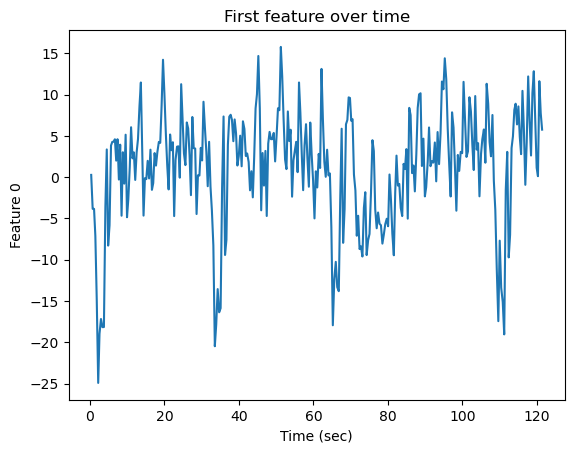

In [44]:
import matplotlib.pyplot as plt

T = X.shape[0]
t = torch.cumsum(durations, dim=0).cpu().numpy()

plt.figure()
plt.plot(t, X[:, 2].cpu().numpy())
plt.xlabel("Time (sec)")
plt.ylabel("Feature 0")
plt.title("First feature over time")
plt.show()


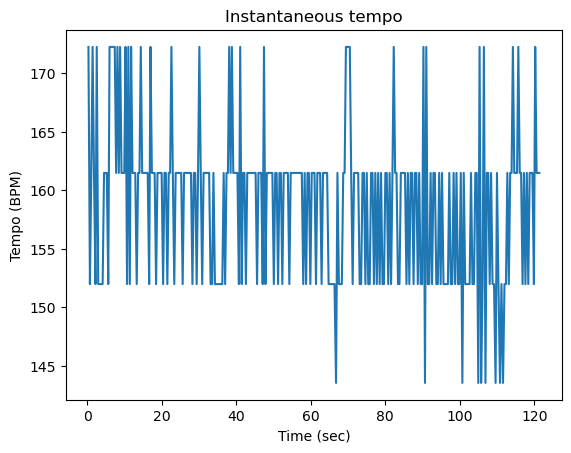

In [45]:
tempo = 60.0 / durations

plt.figure()
plt.plot(t, tempo.cpu().numpy())
plt.xlabel("Time (sec)")
plt.ylabel("Tempo (BPM)")
plt.title("Instantaneous tempo")
plt.show()

In [52]:
dataset = Covers1000Dataset(mat_files)

sample_1 = dataset[0]
sample_2 = dataset[1]

print(sample_1["X"].shape, sample_2["X"].shape)

torch.Size([365, 47]) torch.Size([383, 47])


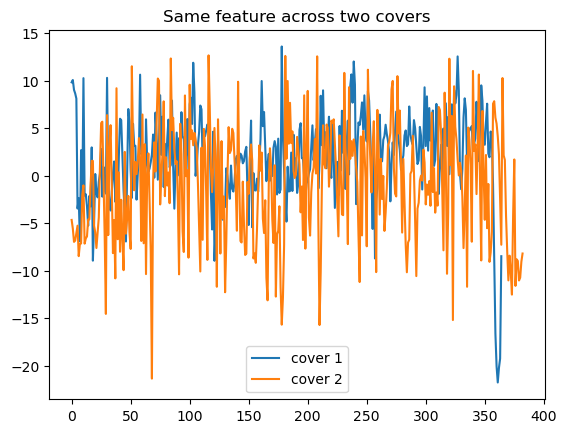

In [55]:
plt.figure()
plt.plot(sample_1["X"][:, 2].cpu(), label="cover 1")
plt.plot(sample_2["X"][:, 2].cpu(), label="cover 2")
plt.legend()
plt.title("Same feature across two covers")
plt.show()